# 第6週：分析PTT進擊的巨人相關文章之詞彙關係



## 1. 套件說明

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [3]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

In [4]:
#匯入資料
df = pd.read_csv('./raw_data/AOT.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,WARgame723,Gossiping,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""shadowdio"", ...",111.83.27.218,2021-04-09 00:46:12,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,ReiFu21,Gossiping,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ilanese"", ""c...",180.177.69.24,2021-04-10 00:53:56,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,RLAPH,Gossiping,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ericcyc0194""...",39.9.73.62,2021-04-10 00:53:56,ptt


### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [5]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...


### 2.3 文章斷詞與整理

In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [7]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [8]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from C:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\week6\dict\dict.txt.big ...
Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.ufaa601e02f9f9d21b4fc09cd2e9fc20d.cache
Loading model cost 1.421 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...,巨人
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...,完結


## 3. 找出重要詞彙 - 以TFIDF為例

### 3.2 應用於資料集（套件）

除了直接用公式計算，也可以使用sklearn中計算詞頻與tf-idf的套件。

DTM 介紹
- Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。   
- DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。

舉例來說，若有三個文件其內容如下：
- 文件1：「今天天氣很好」
- 文件2：「今天是星期五」
- 文件3：「昨天是星期四而且天氣很好」

而這些文件斷完詞後的結果可能為：
- 文件1：「今天／天氣／很／好」
- 文件2：「今天／是／星期五」
- 文件3：「昨天／是／星期四／而且／天氣／很／好」

將這三個文件以DTM格式表示則如下圖：   

<img src="./img/DTM_exsample.png" style="float:left;" width="70%">   

In [9]:
food_df = MetaData.copy()
food_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...


In [10]:
# 保留需要的欄位
food_df = food_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
food_df['word'] = food_df.sentence.apply(getToken).map(' '.join)

food_df.head()

,system_id,sentence,word
0,1,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊 巨人 完結 壓倒性 好評 熱度 持續 神作 巨人 後來者 之姿 挑戰 地位 巨人
1,2,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...,進擊 巨人 終於 完結 總共 劇情 圍繞 巨人 身上 拿掉 巨人 高牆 立體 裝置 雞肋 調...
2,3,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...,這我有 想過 巨人 拿掉 被種 神獸 附身 主角 設定 爸媽 孤兒 主角 神獸 最強 屠城 ...
3,4,我肥宅啦最新一集巨人已經可以在東立線上看了本來還覺得沒什麼結果從看一遍瑪雷篇哇靠完全又是不同...,我肥宅 新一集 巨人 東立線 沒什麼 看一遍 瑪雷篇 領會 完美 解釋 動畫 旁白 當初 旁...
4,5,兩人都留著一頭俏麗短髮個性獨立堅強能力超強一個是期扛壩子一個是台灣最正雖然莎莎身材屌打米卡莎...,兩人 留著 一頭 俏麗短髮 個性 獨立 堅強 能力 超強 壩子 台灣 最正 莎莎 身材 米卡...


In [11]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一丁點,一下下,一下張,一不小心,一世,一中,一之稱,一二,一人,...,龍拳,龍河,龍珠,龍貓,龍貓姫,龐克,龐大,龜山島,龜殼,龜頭
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一丁點,一下下,一下張,一不小心,一世,一中,一之稱,一二,一人,...,龍拳,龍河,龍珠,龍貓,龍貓姫,龐克,龐大,龜山島,龜殼,龜頭
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [13]:
food_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
food_tfidf.columns = ["word", "avg"]

food_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
5302,巨人,0.050271
14188,進擊,0.036519
2984,台灣,0.018498
2499,動畫,0.018163
8068,有沒有,0.017602
1930,八卦,0.017363
9374,漫畫,0.016691
2494,動漫,0.014581
4710,完結篇,0.014147
10663,真的,0.013446


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [14]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一丁點,一下下,一下張,一不小心,一世,一中,一之稱,一二,...,龍拳,龍河,龍珠,龍貓,龍貓姫,龐克,龐大,龜山島,龜殼,龜頭
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677,678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678,679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
10863988,677,龜頭,0.0
10863989,678,龜頭,0.0
10863990,679,龜頭,0.0
10863991,680,龜頭,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [16]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
1778,巨人,40
4348,進擊,35
0,一一,29
1609,完結篇,25
683,八卦,24
840,動畫,23
3016,漫畫,21
1011,台灣,20
821,劇場版,18
4596,電影,18


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

N-gram範例：

### 4.1 Bigram

In [17]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [18]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
food_bigram = food_bigram.explode('word')

food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊 巨人
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,巨人 完結
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,完結 壓倒性


#### 統計最常出現的bigram組合

In [19]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram['word'].value_counts().reset_index()
food_bigram_count.columns = ['word', 'count']

food_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,進擊 巨人,806
1,完整 新聞,87
2,巨人 完結篇,79
3,風吹 無水,54
4,調查 兵團,51
5,劇場版 進擊,51
6,鬼滅 之刃,49
9,完整 新聞標題,44
10,媒體 來源,44
8,新聞 內文,44


### 4.2 Trigram

In [20]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
food_trigram = food_trigram.explode('word')

food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊 巨人 完結
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,巨人 完結 壓倒性
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,完結 壓倒性 好評


#### 統計最常出現的trigram組合

In [21]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram['word'].value_counts().reset_index()
food_trigram_count.columns = ['word', 'count']

food_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,進擊 巨人 完結篇,75
1,劇場版 進擊 巨人,51
2,完整 新聞 連結,44
3,新聞 連結 網址,43
4,完整 新聞 內文,43
5,台北 國際 動漫,26
6,網址 轉載 媒體,24
7,連結 網址 轉載,24
8,進擊 巨人 最終,22
9,轉載 媒體 備註,22


### 4.3 使用自建字典

In [22]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/AOT.txt')

**使用自建辭典進行斷詞與計算**

In [23]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊的巨人
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,完結
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,壓倒性


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [24]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊的巨人 完結
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,完結 壓倒性
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,壓倒性 好評


In [25]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('完整', '新聞'), 87),
 (('進擊的巨人', '完結篇'), 75),
 (('風吹', '無水'), 54),
 (('劇場版', '進擊的巨人'), 51),
 (('鬼滅', '之刃'), 49)]

除了利用N-gram來幫助建立斷詞字典，N-gram也能幫助我們發現詞與詞之間的連貫關係。

接下來針對重新斷詞後的bigram出現頻率最高的前50對進行視覺化，觀察文章的關鍵詞對

In [26]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [27]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

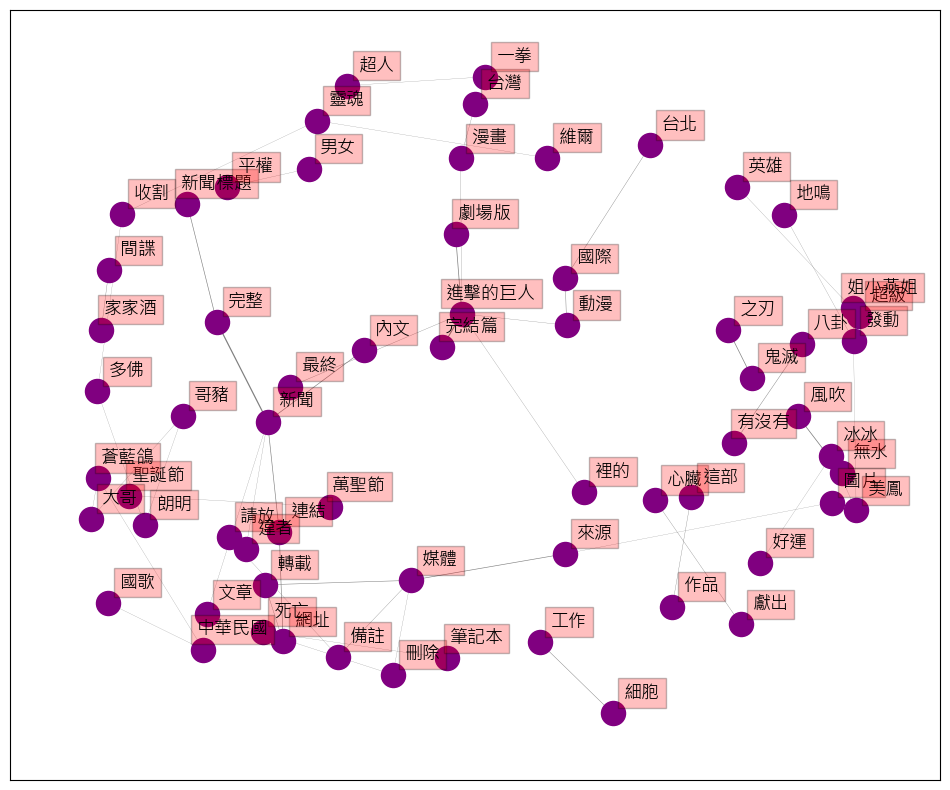

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

使用[numpy.corrcoef](https://numpy.org/doc/2.2/reference/generated/numpy.corrcoef.html)的方法計算

In [29]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊的巨人 完結 壓倒性 好評 熱度 持續 神作 巨人 後來者 之姿 挑戰 地位 巨人
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...,進擊的巨人 終於 完結 總共 劇情 圍繞 巨人 身上 拿掉 巨人 高牆 立體 裝置 雞肋 調...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...,這我有 想過 巨人 拿掉 被種 神獸 附身 主角 設定 爸媽 孤兒 主角 神獸 最強 屠城 ...


In [30]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一堆,一部,一集,七龍珠,上映,不錯,世界,世界觀,中國,主席,...,震撼,靈魂,面對,音樂,預告,類似,飾演,體驗,鬼滅,魔法
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
678,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一堆,一部,一集,七龍珠,上映,不錯,世界,世界觀,中國,...,震撼,靈魂,面對,音樂,預告,類似,飾演,體驗,鬼滅,魔法
0,一堆,1.000000,0.072701,0.055840,0.078647,-0.058390,-0.034676,0.125796,0.086225,0.033846,...,0.083510,-0.011687,0.041359,0.036325,-0.018115,0.136873,0.069118,0.051348,-0.022592,-0.022905
1,一部,0.072701,1.000000,0.253228,0.372757,0.047945,0.156301,0.346991,0.242682,0.032073,...,0.242635,0.132392,0.076619,0.536508,0.133913,0.177987,0.429818,0.155191,0.071000,-0.013678
2,一集,0.055840,0.253228,1.000000,-0.017800,0.040664,0.116518,0.141923,0.002611,-0.013262,...,0.018875,-0.019097,0.018700,0.402183,0.306664,-0.000811,-0.012171,-0.000233,0.219423,-0.010655
3,七龍珠,0.078647,0.372757,-0.017800,1.000000,0.053462,0.103392,0.238802,0.011404,0.032008,...,0.077458,0.257264,-0.004045,0.445530,-0.000609,-0.019971,0.452235,0.079010,0.091665,0.094578
4,上映,-0.058390,0.047945,0.040664,0.053462,1.000000,-0.010643,0.044890,-0.005958,0.099957,...,0.083507,-0.032201,0.029670,0.139412,0.033967,0.050183,-0.020522,0.142911,0.055740,0.020488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,類似,0.136873,0.177987,-0.000811,-0.019971,0.050183,-0.009079,0.294101,0.228416,0.037722,...,0.296713,-0.021427,0.239167,0.080760,0.013477,1.000000,0.054522,0.376322,-0.000885,-0.011955
296,飾演,0.069118,0.429818,-0.012171,0.452235,-0.020522,0.092822,0.207961,0.187530,0.047024,...,0.106228,0.176989,0.087754,0.365545,-0.010926,0.054522,1.000000,0.125799,-0.001731,-0.008050
297,體驗,0.051348,0.155191,-0.000233,0.079010,0.142911,0.143972,0.314570,0.233761,0.000643,...,0.173702,0.064686,0.058005,0.286758,-0.000869,0.376322,0.125799,1.000000,0.009512,-0.011819
298,鬼滅,-0.022592,0.071000,0.219423,0.091665,0.055740,-0.004224,0.052727,-0.017739,-0.008938,...,0.061678,0.132353,-0.018654,0.048260,0.024944,-0.000885,-0.001731,0.009512,1.000000,0.145135


In [32]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
10645,新聞標題,內文,0.976205
43535,內文,新聞標題,0.976205
27584,間諜,家家酒,0.972825
85291,家家酒,間諜,0.972825
16336,改編,原作,0.967083
40854,原作,改編,0.967083
67235,內文,署名,0.963821
67345,新聞標題,署名,0.963821
43724,署名,新聞標題,0.963821
10724,署名,內文,0.963821


### 5.1 和 「調查兵團」, 「訓練兵團」 相關性最高的 10 個詞彙

In [39]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "調查兵團")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "阿爾敏")].sort_values(by = ['cor'], ascending = False).head(10)

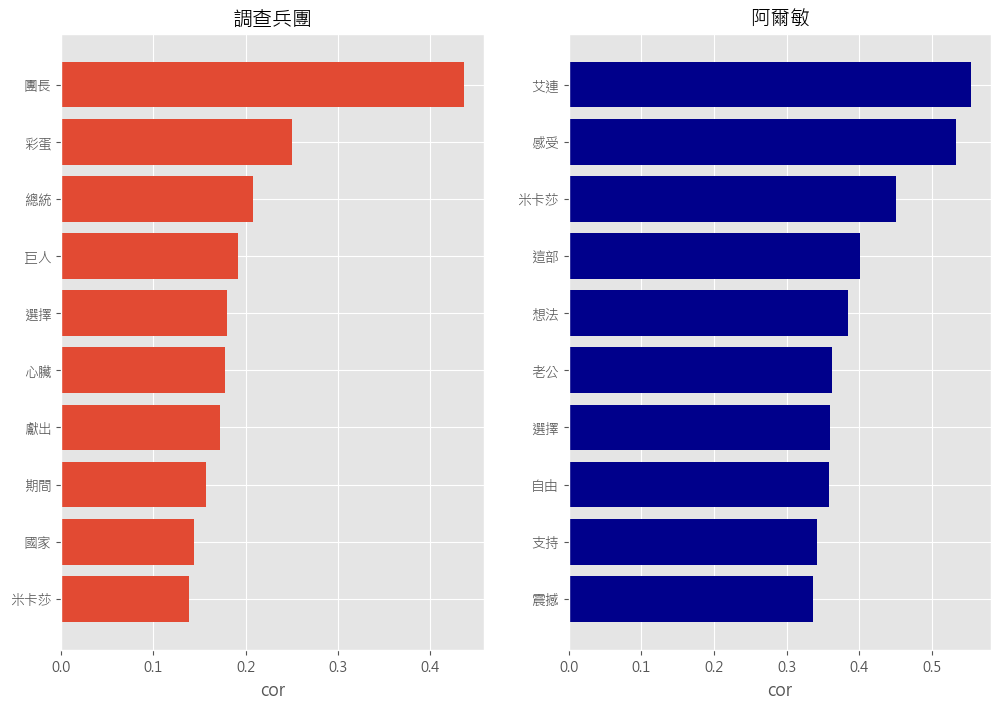

In [40]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('調查兵團')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('阿爾敏')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [41]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [43]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,主角,七龍珠,0.404740
1,作品,七龍珠,0.650900
2,劇情,七龍珠,0.474440
3,真人版,七龍珠,0.652659
4,角色,七龍珠,0.351747
...,...,...,...
339,自由,電影,0.350306
340,觀眾,電影,0.437516
341,角色,電影,0.485261
342,這部,電影,0.528219


In [44]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

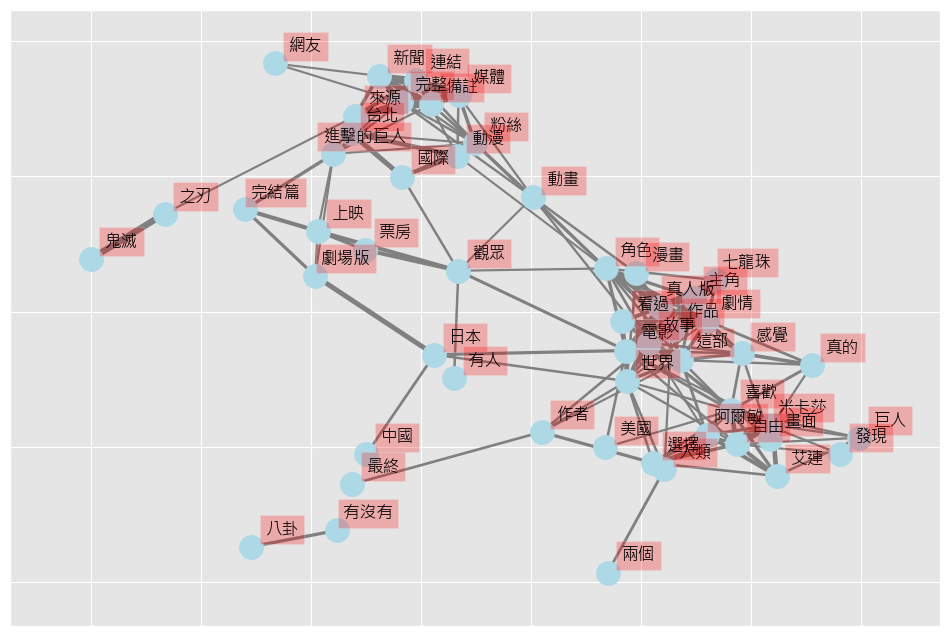

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [46]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1617898345....,[問卦]進擊的巨人跟EVA平起平坐了嗎？,2021-04-09 00:12:23,進擊的巨人 完結了，壓倒性好評\n\nEVA 熱度持續20年的神作\n\n巨人以後來者之姿挑...,進擊的巨人完結了壓倒性好評熱度持續年的神作巨人以後來者之姿挑戰以地位而言巨人並肩了嗎又卦否,進擊的巨人 完結 壓倒性 好評 熱度 持續 神作 巨人 後來者 之姿 挑戰 地位 巨人
1,2,https://www.ptt.cc/bbs/Gossiping/M.1617925959....,[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 07:52:37,進擊的巨人終於完結了\n\n總共139話的劇情\n\n都圍繞在巨人身上\n\n\n但是如果拿...,進擊的巨人終於完結了總共話的劇情都圍繞在巨人身上但是如果拿掉巨人高牆也沒有存在必要立體行動裝...,進擊的巨人 終於 完結 總共 劇情 圍繞 巨人 身上 拿掉 巨人 高牆 立體 裝置 雞肋 調...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1617926905....,Re:[問卦]拿掉巨人進擊的巨人還剩什麼？,2021-04-09 08:08:23,嗯吶\n\n這我有想過\n\n把巨人拿掉\n\n然後變成 一樣是9個人 被9種神獸附身\n\...,嗯吶這我有想過把巨人拿掉然後變成一樣是個人被種神獸附身當然主角照一樣設定爸媽死了變孤兒接著主...,這我有 想過 巨人 拿掉 被種 神獸 附身 主角 設定 爸媽 孤兒 主角 神獸 最強 屠城 ...


In [47]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一堆,一部,一集,七龍珠,上映,不錯,世界,世界觀,中國,主席,...,震撼,靈魂,面對,音樂,預告,類似,飾演,體驗,鬼滅,魔法
0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0.0,0.0,0.0,0.0,0.15748,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
677,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
678,0.0,0.0,0.0,0.0,0.00000,0.125037,0.0,0.0,0.0,0.142922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15419,0.000000,0.0,0.0
679,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.451098,0.0,0.0


計算文章間的cosine similarity

In [48]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [49]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.597056
2,0.150707
3,0.195205
4,0.218618
...,...
676,0.008080
677,0.002809
678,0.005737
679,0.000000


In [50]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[問卦]進擊的巨人跟EVA平起平坐了嗎？,https://www.ptt.cc/bbs/Gossiping/M.1617898345....
609,0.649925,Re:[新聞]安迪馬希提確認為岡恩宇宙蝙蝠俠電影導演,https://www.ptt.cc/bbs/movie/M.1686890261.A.C6...
16,0.635654,[問卦]講進巨的是不是很低端？,https://www.ptt.cc/bbs/Gossiping/M.1617968222....
35,0.631097,[爆卦]台南安平出現進擊的巨人！,https://www.ptt.cc/bbs/Gossiping/M.1618287478....
1,0.597056,[問卦]拿掉巨人進擊的巨人還剩什麼？,https://www.ptt.cc/bbs/Gossiping/M.1617925959....
150,0.591123,Re:[問卦]兩津勘吉進入進擊的巨人世界會怎麼樣?,https://www.ptt.cc/bbs/Gossiping/M.1643883660....
478,0.566306,[問卦]台積電半導體是不是台灣的巨人,https://www.ptt.cc/bbs/Gossiping/M.1701918993....
439,0.511962,[問卦]發掘進巨的班長被判刑十二年?,https://www.ptt.cc/bbs/Gossiping/M.1699510456....
13,0.510500,[問卦]有超越進擊的巨人的作品嗎,https://www.ptt.cc/bbs/Gossiping/M.1617959981....
221,0.492594,[問卦]進擊的巨人馬拉松每天都幾千人在看?,https://www.ptt.cc/bbs/Gossiping/M.1654692884....


檢視與第14篇文章相似的文章

In [51]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
14,1.000000,[問卦]哪部漫畫在大家眼中才算是神結局？,https://www.ptt.cc/bbs/Gossiping/M.1617961202....
218,0.543380,[問卦]不google說得出九大巨人嗎？,https://www.ptt.cc/bbs/Gossiping/M.1652788176....
581,0.501106,[問卦]進擊的巨人能稱上神作嗎?,https://www.ptt.cc/bbs/Gossiping/M.1740805837....
15,0.468827,[問卦]進擊的巨人結局你滿意嗎？,https://www.ptt.cc/bbs/Gossiping/M.1617965325....
13,0.405284,[問卦]有超越進擊的巨人的作品嗎,https://www.ptt.cc/bbs/Gossiping/M.1617959981....
441,0.384805,[問卦]進擊的巨人動畫值得看嗎?,https://www.ptt.cc/bbs/Gossiping/M.1699542344....
36,0.370895,Re:[爆卦]台南安平出現進擊的巨人！,https://www.ptt.cc/bbs/Gossiping/M.1618324361....
3,0.359164,[問卦]進擊的巨人根本就是神作（無雷）,https://www.ptt.cc/bbs/Gossiping/M.1617933418....
325,0.344209,[問卦]只有我不瘋進擊的巨人嗎？,https://www.ptt.cc/bbs/Gossiping/M.1680195422....
451,0.334088,Re:[問卦]女洛基484很渣？,https://www.ptt.cc/bbs/Gossiping/M.1699788418....


## 7. 補充：建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

In [52]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [53]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [54]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [56]:
text = '艾倫'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 米卡莎, probability: 0.0421
next word: 葉卡, probability: 0.0421
next word: 崩潰, probability: 0.0421
next word: </s>, probability: 0.0316
next word: 繼承, probability: 0.0316


In [57]:
text = '巨人'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 之力, probability: 0.0337
next word: </s>, probability: 0.0241
next word: 動畫, probability: 0.0193
next word: 世界, probability: 0.0193
next word: 巨人, probability: 0.0145


# 第七週：文件分類

本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的四個版別文章做示範進行分類器訓練和評估，最後在使用東森新聞的文章進行預測。

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 文字前處理

- 資料來源：Dcard
- 版別：追星、寵物、時事、Youtuber
- 時間範圍：2024/11/01 ~ 2024/11/30
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [ ]:
udn = pd.read_csv("raw_data/追星_寵物_時事_Youtuber.csv")  # 匯資料
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/entertainer/p/257328269,2024/11/25 04:51,#分享 多款浮誇好拍照拿飯撒應援扇分享♡♡,皆さん、こんにちは💛二宮太太ですᙏ̤̫͚ ♡゛\n\n前陣子分享了我的應援扇教學!!\n最近...,entertainer,0,jmimi,F,二宮太太💛
1,2,Dcard,https://www.dcard.tw/f/entertainer/p/257344585,2024/11/27 00:25,#分享 2024MAMA－YEONJUN,https://youtu.be/hXPpqsFIGJw?si=dYUOE4gMoet8LG9d,entertainer,0,lin_10_72,F,🩵안심우🩷
2,3,Dcard,https://www.dcard.tw/f/entertainer/p/257329787,2024/11/25 08:02,#閒聊 B.A.P粉絲社群,BJYM BANG&JUNG&YOO&MOON❤️❤️\n\n\n\n您已被邀請加入「우리 ...,entertainer,0,cathy051289,F,淨淨很安靜


In [ ]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 4488
date range: ('2024/11/1 00:17', '2024/11/9 23:48')
category: 
trending       1441
pet            1196
entertainer     937
youtuber        914
Name: artCatagory, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/entertainer/p/257328269,2024/11/25 04:51,分享多款浮誇好拍照拿飯撒應援扇分享,皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把扇子做完的心得是之前做的也太醜了吧...,entertainer,0,jmimi,F,二宮太太💛
1,2,Dcard,https://www.dcard.tw/f/entertainer/p/257344585,2024/11/27 00:25,分享,,entertainer,0,lin_10_72,F,🩵안심우🩷
2,3,Dcard,https://www.dcard.tw/f/entertainer/p/257329787,2024/11/25 08:02,閒聊粉絲社群,您已被邀請加入請點選以下連結加入社群,entertainer,0,cathy051289,F,淨淨很安靜


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [ ]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,分享多款浮誇好拍照拿飯撒應援扇分享皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把...,https://www.dcard.tw/f/entertainer/p/257328269,entertainer
1,分享,https://www.dcard.tw/f/entertainer/p/257344585,entertainer
2,閒聊粉絲社群您已被邀請加入請點選以下連結加入社群,https://www.dcard.tw/f/entertainer/p/257329787,entertainer
3,集中討論第一張迷你專輯舞台,https://www.dcard.tw/f/entertainer/p/257330597,entertainer
4,閒聊大家有買過黃牛票只要加價就算嗎想知道這裡的人有看過演唱會的人買黃牛票的比例我自己是沒有都...,https://www.dcard.tw/f/entertainer/p/257334902,entertainer


In [ ]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 4179


### 2.2 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from C:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\week07\dict\dict.txt.big ...
Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.u46d1627e410ec4d2996d2d83c1fdb844.cache
Loading model cost 1.412 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,分享多款浮誇好拍照拿飯撒應援扇分享皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把...,https://www.dcard.tw/f/entertainer/p/257328269,entertainer,分享 多款 浮誇 拍照 拿飯 應援 分享 二宮 太太 陣子 分享 應援 教學 最近 接單 好...
1,分享,https://www.dcard.tw/f/entertainer/p/257344585,entertainer,分享
2,閒聊粉絲社群您已被邀請加入請點選以下連結加入社群,https://www.dcard.tw/f/entertainer/p/257329787,entertainer,閒聊 粉絲 社群 邀請 加入 點選 以下 連結 加入 社群
3,集中討論第一張迷你專輯舞台,https://www.dcard.tw/f/entertainer/p/257330597,entertainer,集中 討論 第一張 迷你 專輯 舞台
4,閒聊大家有買過黃牛票只要加價就算嗎想知道這裡的人有看過演唱會的人買黃牛票的比例我自己是沒有都...,https://www.dcard.tw/f/entertainer/p/257334902,entertainer,閒聊 有買過 黃牛票 加價 知道 這裡 看過 演唱會 黃牛票 比例 朋友 刷票 真的 認命 ...


### 2.3 資料集基本檢視

檢視資料內容

In [ ]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 4179
category: 
trending       1319
pet            1117
youtuber        879
entertainer     864
Name: artCatagory, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1518    三款 狗狗 情緒 緩品 分享 毛寶優品 毛孩 時代 快樂 毛子 寶貝 我家 這年 在家 工作...
1794    寵物 推車 最近 年末 好多 寵物 展想 貓貓 買台 推車 有空 逛逛 推車 便宜 六千多 ...
549     閒聊 出演 美劇 白蓮花 大飯店 第三季 樣子 影片 白蓮花 大飯店 電視 目前 受歡迎 劇...
2367    高虹安林智堅 落井下石 凡事 比較 新竹市 現在 感想 揣測 但林智堅 知道 城市 光榮感 ...
2692                                         啟昱 打球 啟昱 第一天
Name: words, dtype: object
1518            pet
1794            pet
549     entertainer
2367       trending
2692       trending
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
trending       31.562575
pet            26.728883
youtuber       21.033740
entertainer    20.674803
Name: artCatagory, dtype: float64

train percentage :
trending       32.649573
pet            26.324786
youtuber       21.299145
entertainer    19.726496
Name: artCatagory, dtype: float64

test percentage :
trending       29.027113
pet            27.671451
entertainer    22.886762
youtuber       20.414673
Name: artCatagory, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

1518    三款 狗狗 情緒 緩品 分享 毛寶優品 毛孩 時代 快樂 毛子 寶貝 我家 這年 在家 工作...
1794    寵物 推車 最近 年末 好多 寵物 展想 貓貓 買台 推車 有空 逛逛 推車 便宜 六千多 ...
549     閒聊 出演 美劇 白蓮花 大飯店 第三季 樣子 影片 白蓮花 大飯店 電視 目前 受歡迎 劇...
2367    高虹安林智堅 落井下石 凡事 比較 新竹市 現在 感想 揣測 但林智堅 知道 城市 光榮感 ...
2692                                         啟昱 打球 啟昱 第一天
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一下,一些,一件,一位,一個月,一名,一堆,一場,一天,一定,...,首次,首歌,香港,駕駛,驅蟲,體驗,高雄,麻煩,麻麻,黃國
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(2925, 1000)
(1254, 1000)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
clf.classes_

array(['entertainer', 'pet', 'trending', 'youtuber'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['trending' 'youtuber' 'pet' 'pet' 'pet' 'pet' 'youtuber' 'pet'
 'entertainer' 'youtuber']


觀察看看模型輸出的類別機率

In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1254, 4)


array([0.02357784, 0.30442894, 0.36847348, 0.30351974])

### 3.4 模型評估
+ 在 scikit-learn 中，classification_report 函數可生成分類模型的性能報告，包含每個類別的主要指標，如精確度（precision）、召回率（recall）、F1 分數（F1-score）和支持數（support）。這些指標有助於評估模型在不同類別上的表現，並提供整體的macro avg和weighted avg分數。

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 entertainer       0.94      0.94      0.94       287
         pet       0.92      0.87      0.90       347
    trending       0.84      0.92      0.88       364
    youtuber       0.81      0.75      0.78       256

    accuracy                           0.88      1254
   macro avg       0.88      0.87      0.87      1254
weighted avg       0.88      0.88      0.88      1254



+ 混淆矩陣（Confusion Matrix）是一種評估分類模型性能的工具，特別適用於分類問題。​它以矩陣形式呈現模型的預測結果與實際標籤之間的對比，幫助識別模型在各類別上的表現。

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[269,   4,   7,   7],
       [  6, 303,  22,  16],
       [  0,   6, 335,  23],
       [ 12,  15,  36, 193]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'entertainer'),
  Text(0, 1.5, 'pet'),
  Text(0, 2.5, 'trending'),
  Text(0, 3.5, 'youtuber')])

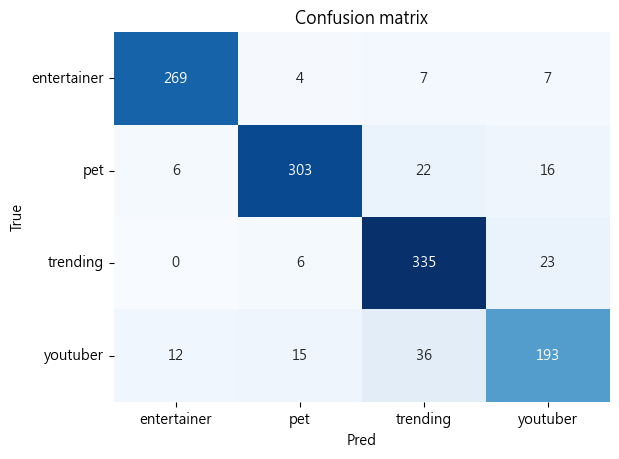

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

除了youtuber版以外其他分類效果都不錯

### 3.5 TF-IDF

改試試看使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果

這邊使用到的TfidfVectorizer 和 上週使用到的TfidfTransformer都是用來計算文本的TF-IDF，不同的是TfidfTransformer適用於已經計算好詞頻的情況。

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一下,一些,一件,一位,一個月,一名,一堆,一場,一天,一定,...,首次,首歌,香港,駕駛,驅蟲,體驗,高雄,麻煩,麻麻,黃國
0,0.0,0.056333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.07568,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2921,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2922,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0


In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 entertainer       0.93      0.93      0.93       287
         pet       0.93      0.90      0.91       347
    trending       0.84      0.93      0.88       364
    youtuber       0.85      0.75      0.80       256

    accuracy                           0.88      1254
   macro avg       0.89      0.88      0.88      1254
weighted avg       0.89      0.88      0.88      1254



效果一樣也是不錯，youtuber版分數有稍微變高

### 3.6 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.11824012, 0.12343502, 0.10279799, 0.1176672 , 0.10585546]),
 'score_time': array([0.0121243 , 0.01144481, 0.01042128, 0.01044202, 0.00941038]),
 'test_f1_macro': array([0.89584881, 0.89048774, 0.88630976, 0.86536946, 0.87872128]),
 'test_precision_macro': array([0.89980635, 0.89538698, 0.89462791, 0.87140649, 0.88704202]),
 'test_recall_macro': array([0.89260402, 0.88667029, 0.88211896, 0.86085661, 0.87445518])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 entertainer       0.94      0.91      0.93       577
         pet       0.93      0.91      0.92       770
    trending       0.86      0.94      0.90       955
    youtuber       0.82      0.76      0.79       623

    accuracy                           0.89      2925
   macro avg       0.89      0.88      0.88      2925
weighted avg       0.89      0.89      0.89      2925



## 4. 比較不同模型效果

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

 entertainer       0.94      0.91      0.93       577
         pet       0.93      0.91      0.92       770
    trending       0.86      0.94      0.90       955
    youtuber       0.82      0.76      0.79       623

    accuracy                           0.89      2925
   macro avg       0.89      0.88      0.88      2925
weighted avg       0.89      0.89      0.89      2925



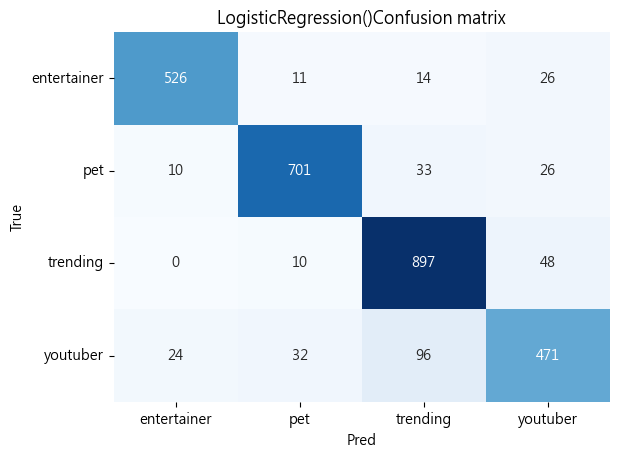

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

 entertainer       0.94      0.91      0.93       577
         pet       0.93      0.91      0.92       770
    trending       0.86      0.94      0.90       955
    youtuber       0.82      0.76      0.79       623

    accuracy                           0.89      2925
   macro avg       0.89      0.88      0.88      2925
weighted avg       0.89      0.89      0.89      2925

now training: clf_dtree
              precision    recall  f1-score   support

 entertainer       0.84      0.86      0.85       577
         pet       0.74      0.82      0.78       770
    trending       0.81      0.77      0.79       955
    youtuber       0.66      0.61      0.63       623

    accuracy                           0.76      2925
   macro avg       0.76      0.76      0.76      2925
weighted avg       0.76      0.76      0.76      2925

now training: clf_svm
              precision    recall  f1-score   support

 e

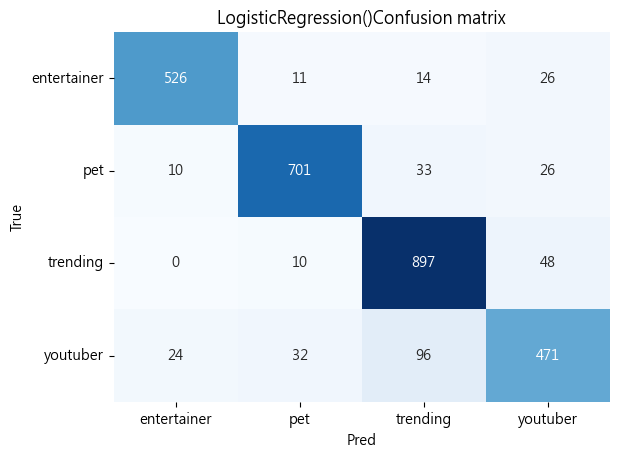

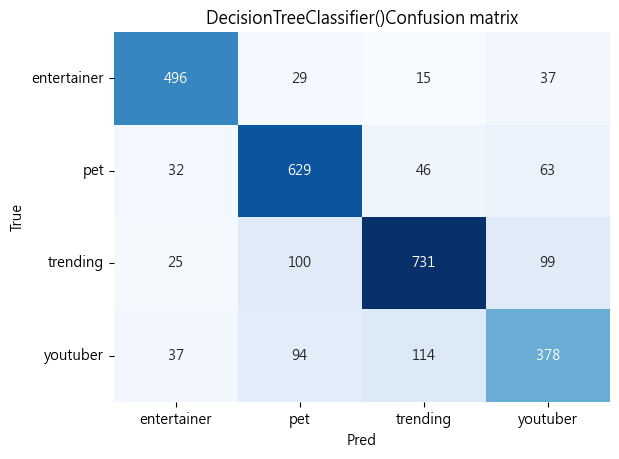

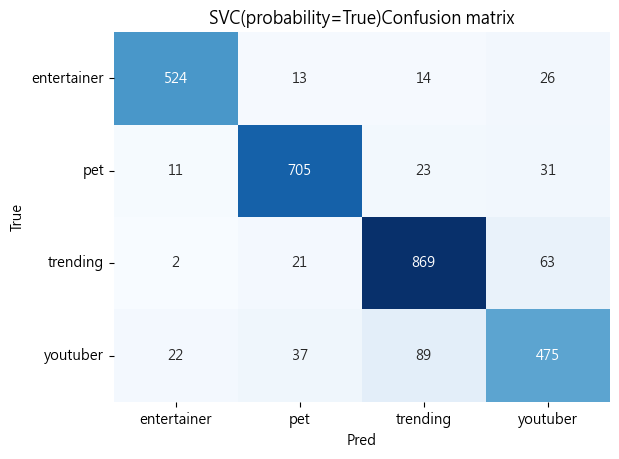

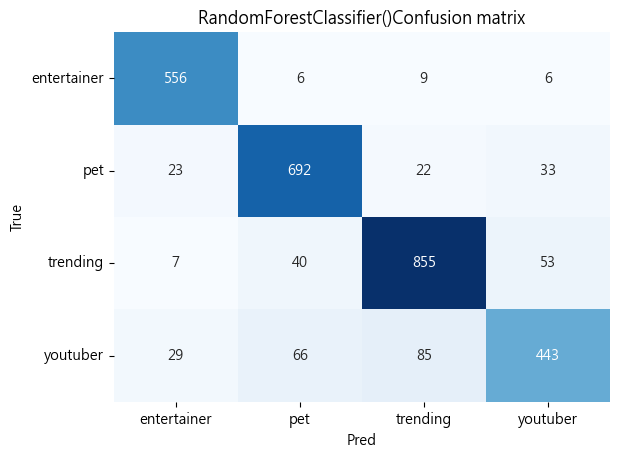

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


分別觀察各個分類模型在不同類別的評估指標表現如何

In [ ]:
result_set['clf_logistic']

{'entertainer': {'precision': 0.9392857142857143,
  'recall': 0.9116117850953206,
  'f1-score': 0.9252418645558486,
  'support': 577},
 'pet': {'precision': 0.9297082228116711,
  'recall': 0.9103896103896104,
  'f1-score': 0.9199475065616798,
  'support': 770},
 'trending': {'precision': 0.8625,
  'recall': 0.9392670157068063,
  'f1-score': 0.8992481203007517,
  'support': 955},
 'youtuber': {'precision': 0.8248686514886164,
  'recall': 0.7560192616372392,
  'f1-score': 0.7889447236180905,
  'support': 623},
 'accuracy': 0.8871794871794871,
 'macro avg': {'precision': 0.8890906471465004,
  'recall': 0.8793219182072441,
  'f1-score': 0.8833455537590926,
  'support': 2925},
 'weighted avg': {'precision': 0.8873243960975221,
  'recall': 0.8871794871794871,
  'f1-score': 0.8863311636247886,
  'support': 2925}}

+ 找出f1-score表現最好的模型是哪個，作為我們最終得到的分類器

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.8871794871794871,
 'entertainer': {'f1-score': 0.9252418645558486,
                 'precision': 0.9392857142857143,
                 'recall': 0.9116117850953206,
                 'support': 577},
 'macro avg': {'f1-score': 0.8833455537590926,
               'precision': 0.8890906471465004,
               'recall': 0.8793219182072441,
               'support': 2925},
 'pet': {'f1-score': 0.9199475065616798,
         'precision': 0.9297082228116711,
         'recall': 0.9103896103896104,
         'support': 770},
 'trending': {'f1-score': 0.8992481203007517,
              'precision': 0.8625,
              'recall': 0.9392670157068063,
              'support': 955},
 'weighted avg': {'f1-score': 0.8863311636247886,
                  'precision': 0.8873243960975221,
                  'recall': 0.8871794871794871,
                  'support': 2925},
 'youtuber': {'f1-score': 0.7889447236180905,
              'precision': 0.8248686514886164,
       

In [ ]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 entertainer       0.94      0.93      0.93       287
         pet       0.90      0.91      0.90       347
    trending       0.85      0.91      0.88       364
    youtuber       0.83      0.75      0.79       256

    accuracy                           0.88      1254
   macro avg       0.88      0.87      0.88      1254
weighted avg       0.88      0.88      0.88      1254



In [ ]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['trending'], dtype=object)

* 最佳的 model 為 logistic

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。
+ 這裡舉logistic regression + cv tokenizer 為例

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

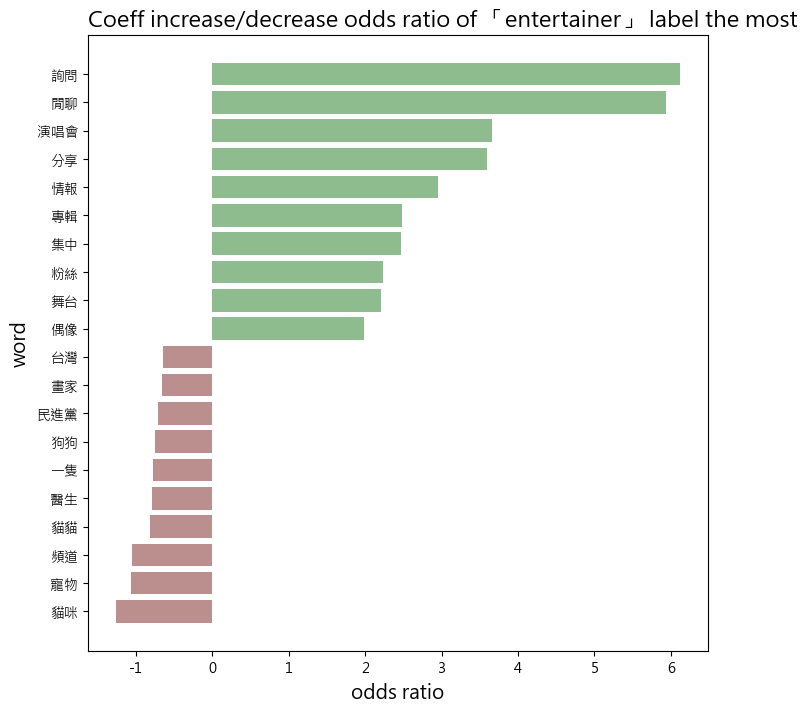

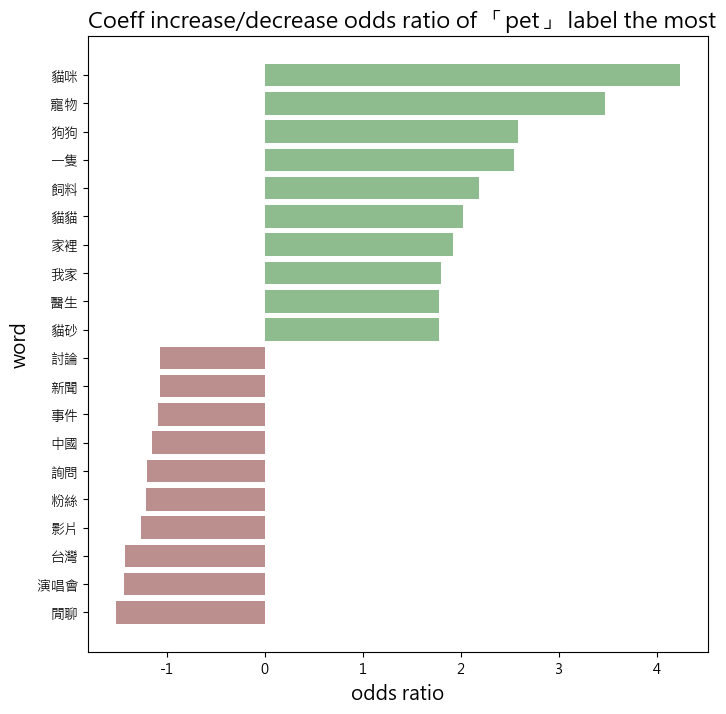

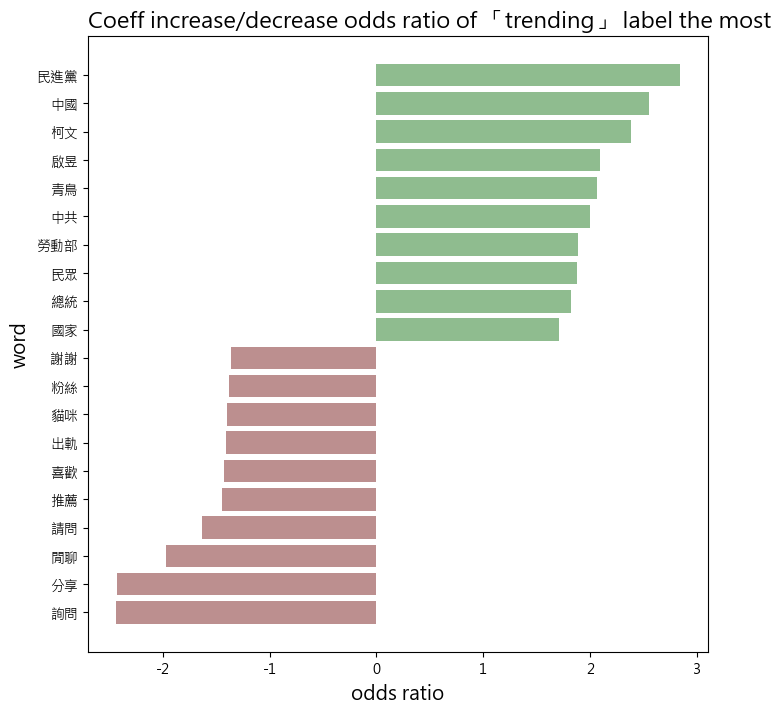

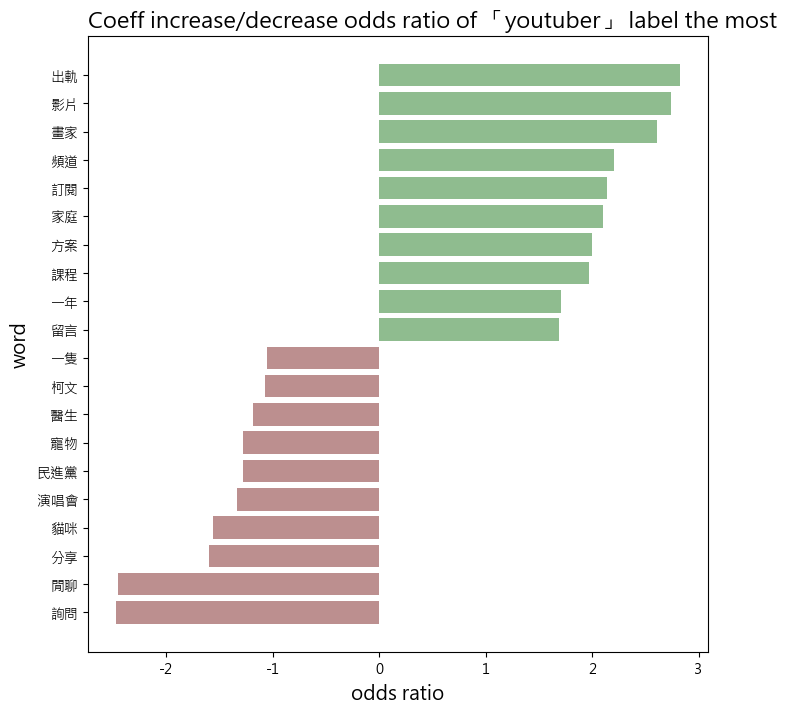

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「youtuber」這段時間有畫家出軌事件的關鍵字

## 6. 用訓練好的分類器來預測其他家的新聞類別

我們前面使用聯合新聞網的資料訓練好了分類器模型，接著用其他家新聞網的資料試試看分類的效果。

- 資料來源：Dcard
- 版別：追星、寵物、時事、Youtuber
- 時間範圍：2025/03/01 ~ 2025/03/15
- 工作流程平台搜尋/排除關鍵字：無

In [ ]:
ct = pd.read_csv("./raw_data/new_追星_寵物_時事_Youtuber.csv")
ct.dropna(inplace=True)
ct

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/entertainer/p/258136958,2025/3/1 08:29,#詢問 K-Flow3演唱會,黃1B-1區5280_1排-19號\n一個人\n有人要嗎!,entertainer,5,macy394831,F,鴨ㄗ
1,2,Dcard,https://www.dcard.tw/f/entertainer/p/258136241,2025/3/1 06:55,#公告 #換票 #kflow3 搖滾區換連號兩張！！！,〔持有〕\n票價 6680\n張數 2\n位置 搖滾C 7xx 9xx\n〔想換〕\n票價 ...,entertainer,0,natalililie,F,nataliewu
3,4,Dcard,https://www.dcard.tw/f/entertainer/p/258135669,2025/3/1 05:46,#新聞 方大同走了？！,\n今天收到這則通知 真的嚇到\n他不是還很年輕？\n不論真假 人真的要活在當下啊！,entertainer,1,you222,F,草莓蛋糕
4,5,Dcard,https://www.dcard.tw/f/entertainer/p/258138957,2025/3/1 12:44,#集中討論 3/30台北場小女友演唱會換票,因為排班原因，我朋友3/30台北場小女友演唱會沒辦法去，所以想換3/23場的票～\n3/30...,entertainer,1,hanzos,F,hanzos
5,6,Dcard,https://www.dcard.tw/f/entertainer/p/258166953,2025/3/4 09:47,#詢問 一起去聽LE SSERAFIM演唱會,有沒有人要一起去聽LE SSERAFIM世巡台北場 本人從去年年底開始追星 但沒什麼有在追星...,entertainer,2,lil_wff,M,嗄
...,...,...,...,...,...,...,...,...,...,...,...
2586,608,Dcard,https://www.dcard.tw/f/youtuber/p/258275206,2025/3/15 16:16,要怎麼只打張家不傷家寧,是說 我看andy拍片 說對家寧的愛沒丟 還有一些網紅說 andy私底下也沒說家寧壞話 在拍...,youtuber,11,milking,M,牛奶味
2587,609,Dcard,https://www.dcard.tw/f/youtuber/p/258264180,2025/3/14 12:25,ChatGPT：家寧回應心虛度75分,各位不用看回應了，都是屁話🤠\n還被GPT嘴：「給人一種試圖控場但底氣不足的感覺」。\n\n...,youtuber,0,uone26,M,暗號
2588,610,Dcard,https://www.dcard.tw/f/youtuber/p/258263604,2025/3/14 11:15,家寧六點聲明解析 \ 你們怎麼看這家人的聲明==？,一\n固定薪資保障生活，那是要是頻道收益低過一個預期你的保障才叫保障阿，要是收益高達千萬你給...,youtuber,19,anxietyapple,M,白貓
2592,614,Dcard,https://www.dcard.tw/f/youtuber/p/258268143,2025/3/15 01:22,事實證明我的方法是有用的,https://www.dcard.tw/f/youtuber/p/258252252?ci...,youtuber,3,機械工程學系,M,國立聯合大學


In [ ]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,#詢問 K-Flow3演唱會黃1B-1區5280_1排-19號\n一個人\n有人要嗎!,https://www.dcard.tw/f/entertainer/p/258136958,entertainer,詢問 Flow3 演唱會 1B 5280 19 有人
1,#公告 #換票 #kflow3 搖滾區換連號兩張！！！〔持有〕\n票價 6680\n張數 2...,https://www.dcard.tw/f/entertainer/p/258136241,entertainer,公告 換票 kflow3 搖滾 區換 連號 兩張 持有 票價 6680 張數 位置 搖滾 7...
3,#新聞 方大同走了？！\n今天收到這則通知 真的嚇到\n他不是還很年輕？\n不論真假 人真的...,https://www.dcard.tw/f/entertainer/p/258135669,entertainer,新聞 方大同 今天 收到 這則 通知 真的 年輕 真假 真的 要活
4,#集中討論 3/30台北場小女友演唱會換票因為排班原因，我朋友3/30台北場小女友演唱會沒辦...,https://www.dcard.tw/f/entertainer/p/258138957,entertainer,集中 討論 30 台北 場小 女友 演唱會 換票 排班 原因 朋友 30 台北 場小 女友 ...
5,#詢問 一起去聽LE SSERAFIM演唱會有沒有人要一起去聽LE SSERAFIM世巡台北...,https://www.dcard.tw/f/entertainer/p/258166953,entertainer,詢問 一起 LE SSERAFIM 演唱會 有沒有 人要 一起 LE SSERAFIM 世巡...


觀察一下資料集的分佈狀況

In [ ]:
ct['artCatagory'].value_counts()

trending       542
pet            376
entertainer    284
youtuber       265
Name: artCatagory, dtype: int64

In [ ]:
X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

 entertainer       0.94      0.89      0.91       284
         pet       0.92      0.89      0.91       376
    trending       0.82      0.95      0.88       542
    youtuber       0.82      0.66      0.73       265

    accuracy                           0.87      1467
   macro avg       0.88      0.85      0.86      1467
weighted avg       0.87      0.87      0.87      1467



youtuber分類表現不好

接著進一步研究分類的結果，嘗試找出問題的原因

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,詢問 Flow3 演唱會 1B 5280 19 有人,entertainer,entertainer
1,公告 換票 kflow3 搖滾 區換 連號 兩張 持有 票價 6680 張數 位置 搖滾 7...,entertainer,entertainer
3,新聞 方大同 今天 收到 這則 通知 真的 年輕 真假 真的 要活,entertainer,trending
4,集中 討論 30 台北 場小 女友 演唱會 換票 排班 原因 朋友 30 台北 場小 女友 ...,entertainer,entertainer
5,詢問 一起 LE SSERAFIM 演唱會 有沒有 人要 一起 LE SSERAFIM 世巡...,entertainer,entertainer
...,...,...,...
2586,張家 不傷 家寧 andy 拍片 對家寧 愛沒 一些 網紅 andy 私底下 說家寧 壞話 ...,youtuber,youtuber
2587,ChatGPT 家寧回 應心 虛度 75 不用 回應 屁話 還被 GPT 給人 一種 試圖 ...,youtuber,youtuber
2588,家寧 六點 聲明 解析 這家 聲明 固定 薪資 保障 生活 頻道 收益 低過 預期 保障 保...,youtuber,youtuber
2592,事實證明 方法 有用 https www dcard tw youtuber 2582522...,youtuber,trending


將錯誤分類的結果篩選出來

In [ ]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
3,新聞 方大同 今天 收到 這則 通知 真的 年輕 真假 真的 要活,entertainer,trending
55,新聞 ElonMusk SpaceX Launches Japanese Star Ado ...,entertainer,trending
62,分享 228 去告 黑心棉 228 紀念日 警局 黑心棉 小時 小時 等待 小時 筆錄 黑心...,entertainer,trending
123,新聞 大陸 出事 機場 接機 嫌車 太爛 下重 手涉 殺人 未遂 移送 大陸 日前 搭機 返...,entertainer,trending
138,情報 配通 詐騙 賣家 售出 商品 一定 貨到付款 轉帳 匯款 黑貓 順豐 配通 最近 網路...,entertainer,trending
...,...,...,...
2567,逆風 喜歡 一億 窮鬼 現在 粉絲 移過去 算是 手段 資產 轉移 網路 敏感度 企劃 確實...,youtuber,trending
2577,宣布 支持 andy 收錢 網軍沒要 講道理 風向 多數 認為 andy 事實上 andy ...,youtuber,trending
2578,網路 霸凌 選擇性 遺忘 所有 自以 理性 旁觀者 一封信 量級 新聞 討論 唯一 心得 打...,youtuber,trending
2585,一首 andy 老師 應援 https youtu be deYzVXhCUWU,youtuber,entertainer


觀察看看youtuber類別的新聞，模型給出的分類結果怎麼樣

In [ ]:
false_pred.loc[false_pred['artCatagory']=='youtuber', :].head(20)

,words,artCatagory,pred
1982,中國 擁有 便宜 特斯拉 FSD 台灣 https youtu be xTlBgtUWd18...,youtuber,trending
1987,DD 板凳 爆米花 買好 看看 最近 蜜瓜 歡迎 聊天室 分享 https www yout...,youtuber,pet
1988,勾惡 幫主 勾惡 幫主 贏了 新聞 已經 保母 勾惡 幫主 求償 100 法官 判勾惡 幫主...,youtuber,trending
1990,川粉 角度看 美烏 會談 看到 機車 這位 YouTuber 影片 提及 川普 覺得 觀點 ...,youtuber,trending
1991,這家 取單 真香 https youtu be OS9UH2ZRk,youtuber,trending
1995,學術 問卷 求助 好心人 幫忙 填寫 論文 問卷 問卷 百元 禮券 互填 抽獎 國立 中央大...,youtuber,pet
1997,基隆 雨港 二二八 鐵絲 集體 拋海 中文字幕 https www youtube com ...,youtuber,trending
1998,米其林 一星 港點 期間 限定 活動 好運 吃過 幾次 算是 不錯 港點 唯一 覺得 美中不...,youtuber,entertainer
2000,依渟挺 騎士 現在 直接 變都 員工 罰款 員工 18 劇情 第一集 還淚 支持 第二級 罰...,youtuber,trending
2005,網友 申請 入學 清華 律師 林智群 晚間 臉書 發文 表示 網友 申請 入學 清華 認同 ...,youtuber,trending


In [ ]:
pprint(false_pred['words'][2020])

('YouTuber 必用 AI 查證 工具 避免 說錯 資訊 信錯 假業配 今天 分享 兩個 實用工具 YouTube 媒體 最怕 無非 第一 說錯 觀眾 '
 '攻擊 公信力 受損 第二 信錯 業配 背上 法律 風險 兩個 痛點 分鐘 努力 付諸流水 賠錢 影響 事業 說錯 風險 YouTuber 熱點 潮流 '
 '時事 搶快 往往 只會 簡單 Google 幾篇 文章 認為 消息 真的 拍片 發表意見 消息 推翻 影片 變成 錯誤 資訊 來源 觀眾 信任感 下降 '
 '嚴重 觀眾 更會 舉報 同行 公開批評 信譽 谷底 難以 翻身 信錯 風險 YouTuber 接業配 機關 企業 合作 確定 對方 可靠 合作方 詐騙 '
 '問題 頻道 拖下水 影響 法律責任 看到 案例 理財 YouTuber 投資 平台 業配 這家 公司 證實 龐氏 騙局 這位 YouTuber 觀眾 '
 '痛罵 幫助 騙子 帶貨 最終 公開 道歉 警方 喝茶 麻煩事 一籮 YouTuber 知道 自保 需要 查證 問題 網上 資訊 真假 混雜 時間 比對 '
 '來源 說法 確認 真偽 資訊 藏得 光靠 Google 搜尋 不到 真正 原始 來源 嚴重 搜尋 容易 SEO 操作 騙子 花錢 資訊 Google '
 '第一頁 真的 找到 有用 資料 還要 逐篇 長文 閱讀 想想 特別 還要 花費 時間 精力 製作 影片 額外 時間 成本 有沒有 快速 方法 答案 善用 '
 'AI 今天 我要 介紹 兩個 工具 解決 問題 而設 兩個 工具 ChatGPT Perplexity ChatGPT 目前 ChatGPT 已經 原本 '
 '要加 200 美元 Deep Research 功能 下放 Plus 用戶 使用 理解 需求 自動 閱讀 總結 最後 自動 生成 一份 完整 調查報告 '
 '全程 30 分鐘 完成 Perplexity Perplexity AI 搜尋器 奠基者 App 專為 搜尋 研究 設計 提供 正確 來源 上線 類似 '
 'ChatGPT Deep research 功能 自動 蒐集 整理 重要 Perplexity 免費 能夠 使用 Deep research 高性價比 '
 '選擇 使用 以下 實用 Prompt 搭配 ChatGPT Perplexi

## 第九週：主題模型（中文）

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 資料前處理

In [ ]:
udn = pd.read_csv("raw_data/追星_寵物_時事_Youtuber.csv")  # 匯資料
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/entertainer/p/257328269,2024/11/25 04:51,#分享 多款浮誇好拍照拿飯撒應援扇分享♡♡,皆さん、こんにちは💛二宮太太ですᙏ̤̫͚ ♡゛\n\n前陣子分享了我的應援扇教學!!\n最近...,entertainer,0,jmimi,F,二宮太太💛
1,2,Dcard,https://www.dcard.tw/f/entertainer/p/257344585,2024/11/27 00:25,#分享 2024MAMA－YEONJUN,https://youtu.be/hXPpqsFIGJw?si=dYUOE4gMoet8LG9d,entertainer,0,lin_10_72,F,🩵안심우🩷
2,3,Dcard,https://www.dcard.tw/f/entertainer/p/257329787,2024/11/25 08:02,#閒聊 B.A.P粉絲社群,BJYM BANG&JUNG&YOO&MOON❤️❤️\n\n\n\n您已被邀請加入「우리 ...,entertainer,0,cathy051289,F,淨淨很安靜


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把扇子做完的心得是之前做的也太醜了吧...,https://www.dcard.tw/f/entertainer/p/257328269,entertainer,2024-11-25 04:51:00
1,,https://www.dcard.tw/f/entertainer/p/257344585,entertainer,2024-11-27 00:25:00
2,您已被邀請加入請點選以下連結加入社群,https://www.dcard.tw/f/entertainer/p/257329787,entertainer,2024-11-25 08:02:00


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

# 篩選掉 content 為空值或空白的資料
udn = udn.dropna(subset=["content"])
udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from C:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\week09\dict\dict.txt.big ...
2025-04-16 17:08:08,847 : DEBUG : Building prefix dict from C:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\week09\dict\dict.txt.big ...
Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.u7a7ff214be0bd343b4244b61b9336a3f.cache
2025-04-16 17:08:08,856 : DEBUG : Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.u7a7ff214be0bd343b4244b61b9336a3f.cache
Loading model cost 3.345 seconds.
2025-04-16 17:08:12,198 : DEBUG : Loading model cost 3.345 seconds.
Prefix dict has been built successfully.
2025-04-16 17:08:12,200 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把扇子做完的心得是之前做的也太醜了吧...,https://www.dcard.tw/f/entertainer/p/257328269,entertainer,2024-11-25 04:51:00,"[二宮, 太太, 陣子, 分享, 應援, 教學, 最近, 接單, 好幾把, 扇子, 心得, ..."
1,,https://www.dcard.tw/f/entertainer/p/257344585,entertainer,2024-11-27 00:25:00,[]
2,您已被邀請加入請點選以下連結加入社群,https://www.dcard.tw/f/entertainer/p/257329787,entertainer,2024-11-25 08:02:00,"[邀請, 加入, 點選, 以下, 連結, 加入, 社群]"
3,舞台,https://www.dcard.tw/f/entertainer/p/257330597,entertainer,2024-11-25 09:37:00,[舞台]
4,想知道這裡的人有看過演唱會的人買黃牛票的比例我自己是沒有都靠朋友刷票真的沒有票的話就認命不去...,https://www.dcard.tw/f/entertainer/p/257334902,entertainer,2024-11-25 17:46:00,"[知道, 這裡, 看過, 演唱會, 黃牛票, 比例, 朋友, 刷票, 真的, 認命, 不去,..."


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

### **4.1 正式處理資料**

將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = udn['words'].to_list()
docs[0]

['二宮',
 '太太',
 '陣子',
 '分享',
 '應援',
 '教學',
 '最近',
 '接單',
 '好幾把',
 '扇子',
 '心得',
 '之前',
 '太醜',
 '比較',
 '心得',
 '找到',
 '之前',
 '還要',
 '快速',
 '方法',
 '有人',
 '再來',
 '分享',
 '以下',
 '應援',
 '抄襲',
 '星野',
 '愛這是',
 '第一次',
 '照片',
 '扇子',
 '照片',
 '大小',
 '真的',
 '成功',
 '這把',
 '上前',
 '兩名',
 '喜歡',
 '顏色',
 '粉色',
 '搭配',
 '小熊',
 '喜歡',
 '用粉',
 '配色',
 '毛絨',
 '玩偶',
 '搭配',
 '毛絨',
 '小熊',
 '外圈',
 '珍珠',
 '時間',
 '黏完',
 '珍珠',
 '檢討',
 '珍珠',
 '價格',
 '愛心',
 '毛絨絨',
 '上面',
 '一位',
 '客人',
 '場內',
 '左右',
 '一起',
 '使用',
 '彈力',
 '蕾絲',
 '整把',
 '綠色',
 '配色',
 '一點點',
 '白色',
 '點綴',
 '駿佑',
 '小狗狗',
 '整把',
 '粉紅色',
 '配色',
 '狗狗',
 '耳朵',
 '搭配',
 '狗狗',
 '玩偶',
 '搭配',
 '下來',
 '超級',
 '可愛',
 '駿佑',
 '小狗狗',
 '這把',
 '黃粉',
 '配色',
 '搭配',
 '小狗狗',
 '玩偶',
 '還配',
 '貓爪',
 '貓狗',
 '雙全',
 '這把',
 '比較',
 '特別',
 '雙面',
 '三秒',
 '第一次',
 '扇子',
 '純文字',
 '客人',
 '提出',
 '想要',
 '反光',
 '材質',
 '希望',
 '超級',
 '亮駿',
 '簡約',
 '款朋朋',
 '朋朋找',
 '扇子',
 '知道',
 '簡約',
 '風格',
 '還多',
 '確認',
 '不可',
 '已經',
 '簡約',
 '需求',
 '還要',
 '裝飾',
 '之前',
 '溝通',
 '底層',
 '波浪',
 '覺得',
 '有點',
 '單調',
 '增加',


建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-16 17:08:42,106 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-16 17:08:42,854 : INFO : built Dictionary<46814 unique tokens: ['一些', '一位', '一起', '一點', '一點點']...> from 4179 documents (total 305429 corpus positions)
2025-04-16 17:08:42,856 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<46814 unique tokens: ['一些', '一位', '一起', '一點', '一點點']...> from 4179 documents (total 305429 corpus positions)", 'datetime': '2025-04-16T17:08:42.856112', 'gensim': '4.3.3', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-04-16 17:08:42,949 : INFO : discarding 39121 tokens: [('三秒', 2), ('二宮', 1), ('亮駿', 1), ('以綠黃', 1), ('北海道', 2), ('反光', 3), ('台灣前', 1), ('名牌', 3), ('吸取經驗', 1), ('單調', 3)]...
2025-04-16 17:08:42,951 : INFO : keeping 7693 tokens which were in no less than 5 and no more than 4137 (=99.0%) documents
2025-04-16 17:08:42,993 : INFO : resultin

Dictionary<7693 unique tokens: ['一些', '一位', '一起', '一點', '一點點']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一些: 0
一位: 1
一起: 2
一點: 3
一點點: 4
上前: 5
上面: 6
下來: 7
不可: 8
不接: 9
主要: 10
之前: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))

('確定 有沒有 活動 水舞 廣場 舉辦 永豐 百年 展覽 活動 安排 歌手 演出 名單 還滿 亮眼 咖徐佳瑩 韋禮安 艾怡良 分別 擔任 三天 壓台 剛攻 '
 '完小 巨蛋 最近 行程 滿檔 先生 今年 金曲 歌后 孫盛希 棒棒糖 小煜梁 文音 李佳歡 感覺 好像 已經 很久沒 看到 多大 同台 有沒有 最想 '
 '哪場 每場 一次 好聽 哈哈哈')


第600篇文章的前十個詞彙的語料庫ID和頻率

In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(47, 1),
 (76, 1),
 (186, 1),
 (209, 1),
 (236, 2),
 (254, 1),
 (343, 2),
 (368, 1),
 (492, 1),
 (522, 1)]

#### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### **4.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-04-16 17:08:43,504 : INFO : using symmetric alpha at 0.1
2025-04-16 17:08:43,507 : INFO : using symmetric eta at 0.1
2025-04-16 17:08:43,514 : INFO : using serial LDA version on this node
2025-04-16 17:08:43,537 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 4179 documents, updating model once every 2000 documents, evaluating perplexity every 4179 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 17:08:43,539 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-16 17:08:43,541 : INFO : PROGRESS: pass 0, at document #2000/4179
2025-04-16 17:08:45,968 : INFO : merging changes from 2000 documents into a model of 4179 documents
2025-04-16 17:08:45,985 : INFO : topic #8 (0.100): 0.016*"貓咪" + 0.012*"真的" + 0.008*"知道" + 0.006*"目前" + 0.006*"覺得" + 0.005*"醫生" + 0.005*"比較" + 0.005*"看到" + 0.005*"喜歡" + 0.005*"有沒有"
2025-04-16 17:0

### **4.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [ ]:
ldamodel.print_topics()

2025-04-16 17:08:48,392 : INFO : topic #0 (0.100): 0.031*"畫家" + 0.018*"影片" + 0.013*"知道" + 0.013*"覺得" + 0.009*"真的" + 0.008*"感覺" + 0.007*"已經" + 0.007*"美國" + 0.007*"現在" + 0.006*"看到"
2025-04-16 17:08:48,397 : INFO : topic #1 (0.100): 0.011*"出軌" + 0.009*"真的" + 0.008*"覺得" + 0.007*"中共" + 0.007*"現在" + 0.007*"知道" + 0.005*"表示" + 0.005*"台灣" + 0.005*"應該" + 0.005*"認為"
2025-04-16 17:08:48,403 : INFO : topic #2 (0.100): 0.015*"夫妻" + 0.010*"方案" + 0.010*"家庭" + 0.009*"小孩" + 0.008*"看到" + 0.007*"現在" + 0.007*"請問" + 0.007*"之前" + 0.006*"一年" + 0.006*"問題"
2025-04-16 17:08:48,406 : INFO : topic #3 (0.100): 0.009*"遊戲" + 0.007*"真的" + 0.006*"音樂" + 0.006*"覺得" + 0.006*"看到" + 0.005*"應該" + 0.005*"台灣" + 0.004*"直播" + 0.004*"希望" + 0.004*"知道"
2025-04-16 17:08:48,412 : INFO : topic #4 (0.100): 0.015*"觀看" + 0.014*"更新" + 0.014*"最新" + 0.012*"完整" + 0.012*"內容" + 0.011*"版本" + 0.010*"轉貼" + 0.010*"文章" + 0.009*"篇文章" + 0.009*"知道"
2025-04-16 17:08:48,416 : INFO : topic #5 (0.100): 0.011*"中國" + 0.009*"台灣" + 0.009*"影片" + 0.006*"真的" + 0

[(0,
  '0.031*"畫家" + 0.018*"影片" + 0.013*"知道" + 0.013*"覺得" + 0.009*"真的" + 0.008*"感覺" + 0.007*"已經" + 0.007*"美國" + 0.007*"現在" + 0.006*"看到"'),
 (1,
  '0.011*"出軌" + 0.009*"真的" + 0.008*"覺得" + 0.007*"中共" + 0.007*"現在" + 0.007*"知道" + 0.005*"表示" + 0.005*"台灣" + 0.005*"應該" + 0.005*"認為"'),
 (2,
  '0.015*"夫妻" + 0.010*"方案" + 0.010*"家庭" + 0.009*"小孩" + 0.008*"看到" + 0.007*"現在" + 0.007*"請問" + 0.007*"之前" + 0.006*"一年" + 0.006*"問題"'),
 (3,
  '0.009*"遊戲" + 0.007*"真的" + 0.006*"音樂" + 0.006*"覺得" + 0.006*"看到" + 0.005*"應該" + 0.005*"台灣" + 0.004*"直播" + 0.004*"希望" + 0.004*"知道"'),
 (4,
  '0.015*"觀看" + 0.014*"更新" + 0.014*"最新" + 0.012*"完整" + 0.012*"內容" + 0.011*"版本" + 0.010*"轉貼" + 0.010*"文章" + 0.009*"篇文章" + 0.009*"知道"'),
 (5,
  '0.011*"中國" + 0.009*"台灣" + 0.009*"影片" + 0.006*"真的" + 0.005*"現在" + 0.005*"覺得" + 0.005*"問題" + 0.004*"有人" + 0.004*"應該" + 0.004*"播放"'),
 (6,
  '0.018*"出軌" + 0.015*"台灣" + 0.012*"畫家" + 0.009*"訂閱" + 0.009*"中國" + 0.008*"應該" + 0.006*"立委" + 0.006*"一定" + 0.005*"已經" + 0.005*"發文"'),
 (7,
  '0.010*"覺得" + 0.010

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：畫家事件
+ 主題二：出軌相關
+ 主題三：家庭相關
+ 主題四：遊戲直播相關
+ 主題五：youtuber相關
+ ...
+ 主題十：政治相關

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.5612036), (3, 0.35204244), (7, 0.083485015)]

這邊可以看到corpus[0]這篇文章是由多個主題混合組成，每個主題都有其機率（權重）
其中主題4的佔比最高(0.77)

### **4.4 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-16 17:08:54,398 : INFO : -9.061 per-word bound, 534.1 perplexity estimate based on a held-out corpus of 4179 documents with 234978 words


-9.060836434357002

將 對數 perplexity 值轉回原始的 perplexity 值

In [ ]:
np.exp2(-perplexity)

534.0520082740635

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-04-16 17:08:54,466 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2025-04-16 17:09:16,365 : INFO : 1 batches submitted to accumulate stats from 64 documents (3421 virtual)
2025-04-16 17:09:16,369 : INFO : 2 batches submitted to accumulate stats from 128 documents (6785 virtual)
2025-04-16 17:09:16,373 : INFO : 3 batches submitted to accumulate stats from 192 documents (8551 virtual)
2025-04-16 17:09:16,376 : INFO : 4 batches submitted to accumulate stats from 256 documents (11573 virtual)
2025-04-16 17:09:16,380 : INFO : 5 batches submitted to accumulate stats from 320 documents (14015 virtual)
2025-04-16 17:09:16,386 : INFO : 6 batches submitted to accumulate stats from 384 documents (17859 virtual)
2025-04-16 17:09:16,391 : INFO : 7 batches submitted to accumulate stats from 448 documents (20850 virtual)
2025-04-16 17:09:16,395 : INFO : 8 batches submitted to accumulate stats from 512 documents (25392 v

這個主題模型的 PMI score:  -0.0428757735741789


也可以列出主題模型中，每個主題詞語之間的PMI score

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.02146454930303988,
 -0.01723078188039244,
 -0.0788340802094655,
 -0.0107393922205623,
 -0.010609954214632159,
 -0.03853871521705809,
 -0.12458777534835742,
 -0.03782525876481078,
 0.004789351905660369,
 -0.09371658048913076]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### **4.5 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2025-04-16 17:09:19,683 : INFO : using symmetric alpha at 0.5
2025-04-16 17:09:19,686 : INFO : using symmetric eta at 0.5
2025-04-16 17:09:19,694 : INFO : using serial LDA version on this node
2025-04-16 17:09:19,701 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 4179 documents, updating model once every 2000 documents, evaluating perplexity every 4179 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 17:09:19,703 : INFO : PROGRESS: pass 0, at document #2000/4179
2025-04-16 17:09:22,179 : INFO : merging changes from 2000 documents into a model of 4179 documents
2025-04-16 17:09:22,183 : INFO : topic #0 (0.500): 0.010*"真的" + 0.009*"貓咪" + 0.007*"知道" + 0.006*"看到" + 0.006*"覺得" + 0.005*"希望" + 0.004*"目前" + 0.004*"現在" + 0.004*"一直" + 0.004*"感覺"
2025-04-16 17:09:22,186 : INFO : topic #1 (0.500): 0.009*"真的" + 0.006*"喜歡" + 0.006*"寵物" + 0.006*"知道" + 0.005*"貓咪" + 0.005*"看到" + 0.005*"希望" + 0.005*"覺得" + 0.005*"一起" + 0.005*"

花費時間: 284.90100502967834 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3748.275029,-0.010346
1,3,3442.753759,-0.000012
2,4,3147.280239,0.004156
3,5,3187.884862,0.012905
4,6,3290.663138,-0.035365
5,7,3271.295469,-0.044512
6,8,3361.461021,-0.061431
7,9,3358.763324,-0.041885


<AxesSubplot:xlabel='topic_num'>

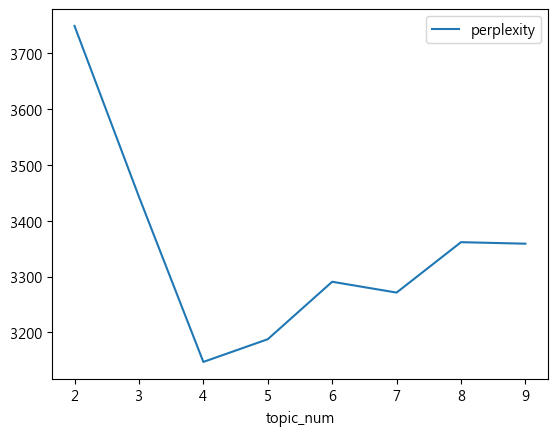

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

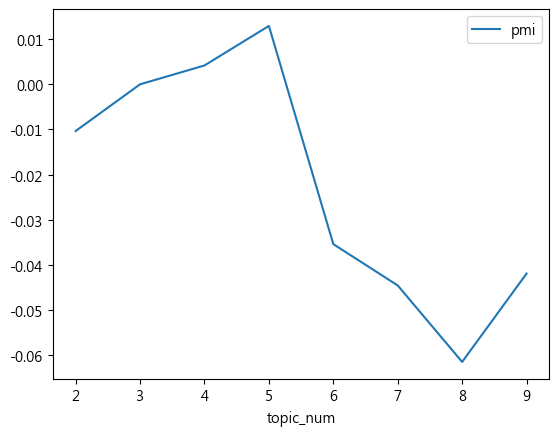

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 8

## 5. 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-04-16 17:14:04,981 : INFO : using symmetric alpha at 0.2
2025-04-16 17:14:04,982 : INFO : using symmetric eta at 0.2
2025-04-16 17:14:04,984 : INFO : using serial LDA version on this node
2025-04-16 17:14:04,991 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 4179 documents, updating model once every 2000 documents, evaluating perplexity every 4179 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 17:14:04,992 : INFO : PROGRESS: pass 0, at document #2000/4179
2025-04-16 17:14:06,349 : INFO : merging changes from 2000 documents into a model of 4179 documents
2025-04-16 17:14:06,353 : INFO : topic #0 (0.200): 0.009*"真的" + 0.009*"貓咪" + 0.006*"覺得" + 0.006*"看到" + 0.004*"目前" + 0.004*"飼料" + 0.004*"現在" + 0.004*"小貓" + 0.004*"知道" + 0.004*"希望"
2025-04-16 17:14:06,354 : INFO : topic #1 (0.200): 0.008*"真的" + 0.006*"粉絲" + 0.006*"寵物" + 0.006*"覺得" + 0.005*"希望" + 0.005*"喜歡" + 0.005*"看到" + 0.005*"一起" + 0.005*"貓咪" + 0.004*"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.149392 -0.166313       1        1  34.150005
0     -0.275202 -0.030752       2        1  23.539378
2      0.012477  0.119102       3        1  17.366889
3      0.115337  0.128283       4        1  14.293649
1     -0.002005 -0.050320       5        1  10.650079, topic_info=     Term         Freq        Total Category  logprob  loglift
6308   中共   942.000000   942.000000  Default  30.0000  30.0000
727    中國   943.000000   943.000000  Default  29.0000  29.0000
807    台灣  1229.000000  1229.000000  Default  28.0000  28.0000
784    美國   873.000000   873.000000  Default  27.0000  27.0000
4804   畫家   593.000000   593.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
76     最近    89.177624   545.206183   Topic5  -5.6370   0.4291
25     分享    84.677462   470.727888   Topic5  -5.6888   0.5242
884    歡迎    75.495603   296.471355   Topic5  -5.8036   0.8717
139    一下    87.589654   668.039044   Topic5  -5.6550   0.2079
657    帳號    72.483414   249.703744   Topic5  -5.8443   1.0027

[395 rows x 6 columns], token_table=      Topic      Freq Term
term                      
139       1  0.589786   一下
139       2  0.002994   一下
139       3  0.085324   一下
139       4  0.188612   一下
139       5  0.131729   一下
...     ...       ...  ...
858       1  0.025673   體感
858       3  0.885716   體感
858       4  0.038509   體感
858       5  0.051346   體感
5366      5  0.981312   鬣蜥

[887 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-16 17:14:25,515 : INFO : using symmetric alpha at 0.25
2025-04-16 17:14:25,516 : INFO : using symmetric eta at 0.25
2025-04-16 17:14:25,519 : INFO : using serial LDA version on this node
2025-04-16 17:14:25,528 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 4179 documents, updating model once every 2000 documents, evaluating perplexity every 4179 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-16 17:14:25,530 : INFO : PROGRESS: pass 0, at document #2000/4179
2025-04-16 17:14:27,930 : INFO : merging changes from 2000 documents into a model of 4179 documents
2025-04-16 17:14:27,936 : INFO : topic #0 (0.250): 0.015*"貓咪" + 0.010*"真的" + 0.006*"覺得" + 0.005*"看到" + 0.005*"希望" + 0.005*"目前" + 0.004*"現在" + 0.004*"飼料" + 0.004*"知道" + 0.004*"感覺"
2025-04-16 17:14:27,939 : INFO : topic #1 (0.250): 0.009*"真的" + 0.007*"貓咪" + 0.006*"粉絲" + 0.006*"喜歡" + 0.006*"希望" + 0.005*"寵物" + 0.005*"覺得" + 0.005*"看到" + 0.004*"一起" + 0.004

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.176035 -0.090919       1        1  33.386776
0      0.196694 -0.098736       2        1  31.174082
2     -0.053307  0.032296       3        1  18.414903
3      0.032648  0.157360       4        1  17.024240, topic_info=     Term         Freq        Total Category  logprob  loglift
6308   中共   820.000000   820.000000  Default  30.0000  30.0000
469    影片  1082.000000  1082.000000  Default  29.0000  29.0000
727    中國   863.000000   863.000000  Default  28.0000  28.0000
3156   貓咪   648.000000   648.000000  Default  27.0000  27.0000
106    覺得  1257.000000  1257.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
305    這是   128.760193   401.218253   Topic4  -5.7388   0.6340
11     之前   130.707745   462.206019   Topic4  -5.7238   0.5075
209    感覺   131.445635   556.043706   Topic4  -5.7181   0.3283
83     比較   130.225821   521.796596   Topic4  -5.7274   0.3825
807    台灣   130.561422  1265.357275   Topic4  -5.7249  -0.5007

[307 rows x 6 columns], token_table=      Topic      Freq Term
term                      
139       1  0.151609   一下
139       2  0.464608   一下
139       3  0.055427   一下
139       4  0.327671   一下
1757      1  0.023832   一方
...     ...       ...  ...
4900      2  0.984786   驅蟲
858       1  0.948973   體感
858       2  0.047847   體感
5366      1  0.992684   鬣蜥
5366      2  0.013236   鬣蜥

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 7. 主題分佈的應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.029327301), (1, 0.054027703), (4, 0.90922225)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.        , 0.        , 0.        , 0.07974453, 0.91738731],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.02532293, 0.89849603, 0.02519342, 0.0253865 , 0.0256011 ],
       ...,
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.02010206, 0.14207645, 0.02041301, 0.02043417, 0.79697436],
       [0.02011052, 0.91890574, 0.02016164, 0.02045772, 0.02036432]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
udn['topic_label'].value_counts()

topic_label
5    1859
1     770
3     644
4     474
2     432
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,皆二宮太太前陣子分享了我的應援扇教學最近因為接單做了好幾把扇子做完的心得是之前做的也太醜了吧...,https://www.dcard.tw/f/entertainer/p/257328269,entertainer,2024-11-25 04:51:00,"[二宮, 太太, 陣子, 分享, 應援, 教學, 最近, 接單, 好幾把, 扇子, 心得, ...",5
1,,https://www.dcard.tw/f/entertainer/p/257344585,entertainer,2024-11-27 00:25:00,[],1
2,您已被邀請加入請點選以下連結加入社群,https://www.dcard.tw/f/entertainer/p/257329787,entertainer,2024-11-25 08:02:00,"[邀請, 加入, 點選, 以下, 連結, 加入, 社群]",2
3,舞台,https://www.dcard.tw/f/entertainer/p/257330597,entertainer,2024-11-25 09:37:00,[舞台],5
4,想知道這裡的人有看過演唱會的人買黃牛票的比例我自己是沒有都靠朋友刷票真的沒有票的話就認命不去...,https://www.dcard.tw/f/entertainer/p/257334902,entertainer,2024-11-25 17:46:00,"[知道, 這裡, 看過, 演唱會, 黃牛票, 比例, 朋友, 刷票, 真的, 認命, 不去,...",5


#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-11-01  5              0.490196
            3              0.209150
            1              0.137255
            4              0.084967
            2              0.078431
                             ...   
2024-11-30  5              0.465649
            1              0.259542
            3              0.122137
            2              0.106870
            4              0.045802
Name: proportion, Length: 150, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-11-01,0.137255,0.078431,0.209150,0.084967,0.490196
2024-11-02,0.194245,0.115108,0.165468,0.093525,0.431655
2024-11-03,0.176871,0.081633,0.170068,0.054422,0.517007
2024-11-04,0.183206,0.106870,0.152672,0.061069,0.496183
2024-11-05,0.268456,0.114094,0.134228,0.067114,0.416107


#### 視覺化呈現主題文章趨勢變化

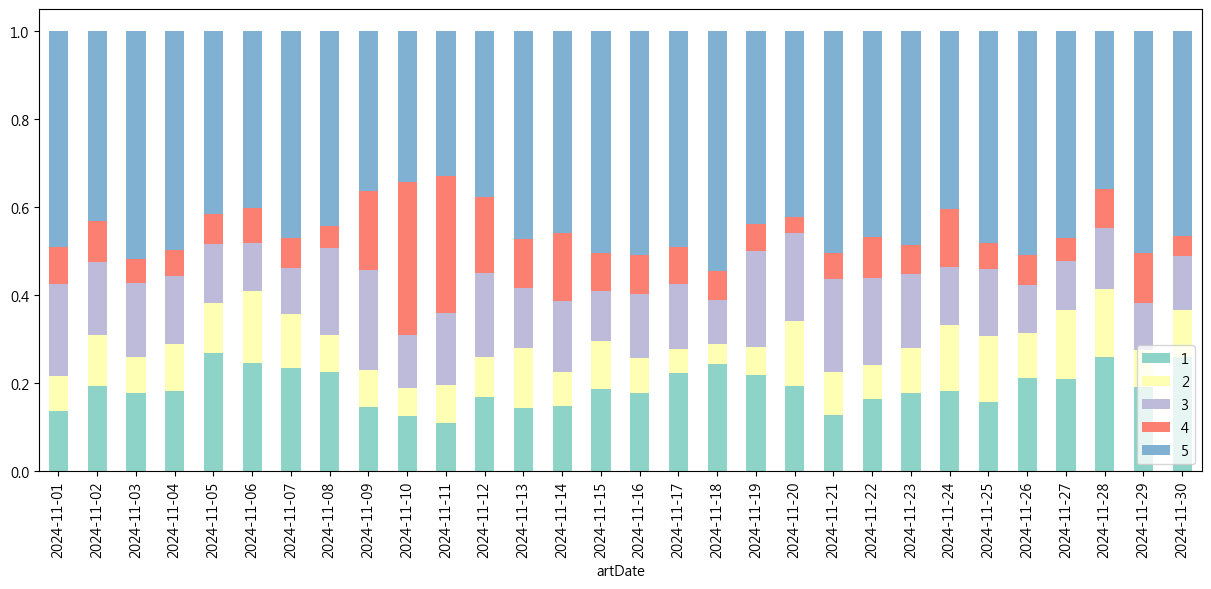

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題4（時事）在 11/10、11/11 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。

In [ ]:
# 確保 artDate 是 datetime 格式
udn["artDate"] = pd.to_datetime(udn["artDate"])

# 篩選主題、日期的資料
filtered = udn[(udn["artDate"].dt.date == pd.to_datetime("2024-11-10").date()) & (udn["topic_label"] == 4)]

filtered['content'].head(20) # 顯示前幾筆資料

358     發一個陰陽怪氣的文章來嗆我你講說演唱會什麼嘴形沒對上真不知道自己家的也是對嘴而已嗎但為啥自己...
392     之前覺得中粉在視訊簽售要求的掐脖舞好噁原來我討厭的不是掐脖舞而是土味音樂和沒有美感的舞蹈還有...
398     想不到欸賴耀翔的票數斷層上升把帝翁擠出去了也算是皇天不負苦心人吧等待了這麼久應該是離出道最近...
542     剛剛看到一個留言想反駁但是也不知道要反駁什麼原本影片是有出現福富月直拍底下留言就有留言到一個...
2420        多慧再度登上新聞版面那看看多慧害怕的神情到底是哪支哥布林跟蹤偷拍啦還是女哥布林忌妒派人去的
2478    看到一堆民進黨支持者或是其他人一直講敢跟中共打仗還笑別人投降主義但叫他敢露臉拍影片幹中共嗎就...
2489    如題最近偶然在隔壁版看到這篇是否該全面禁止支語抖音小紅書雖然老生常談不過因為沒有標準答案一直...
3791    交往超過十年的前妻大爆料帶新人帶到床上去了大書之後也出來拍影片道歉了大書這一對沒有小王另一對...
3809                                         別再出來硬凹丟女生的臉了
3828    結論就是那位中國女畫家很雷這一切的源頭其實並不是一開始發的那篇文因為大家早就看出他們兩人的關...
3844    女畫家反擊一剛開始發現老婆出軌時渾身發麻卻沒有對她發過任何一次脾氣還自責說可能我給不了想要的...
3866    從昨天被小三爆料開始至今完全神隱超過小時的機會你經紀公司擬不出一篇稿來沒做可以快點否認有做可...
3873    最終更文更補充小細節進來昨天看下來發現好多事情爆發才加入的吃瓜民眾不分青紅皂白的亂噴所以想要...
3874    雖然一看到和的事情我也蠻驚訝但人的感情本來就會隨時間因為遇到不同的人事物而發生改變不管是感情...
3876    四個人都非常糟糕呢許多其他帖文已經指出了的不當行為而加以分析我認為我冇必要再發千篇一律的文章...
3882    就結果論來說都各自再找了另一半當然現在的方向會有人希望找到他們在婚姻中是誰先出軌誰先對不起誰...
3883    你說都很早睡或熬夜工作不知道自己昨晚湧進大量留言所以消失可以理解結果現在都隔天中午了日本甚至...
3884    再次更新我對

發現這兩天有些網紅、畫家的出軌事件，所以討論的文章變多

這篇發在youtuebr版的文章，可能有一些新聞、媒體、法律、合約、道歉的關鍵字，所以被分在時事版

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。